In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# MNIST
* Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them.
* Warning: since Scikit-Learn 0.24, fetch_openml() returns a Pandas DataFrame by default. To avoid this, use as_frame=False.

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

* There are 70,000 images, and each image has 784 features. This is because each image is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).
* Let’s take a peek at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a 28×28 array, and display it

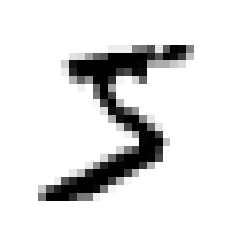

In [8]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

This looks like a 5, and indeed that’s what the label tells us:

In [9]:
y[0]

'5'

You should always create a test set and set it aside before inspecting the data closely. The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Let’s also shuffle the training set; this will guarantee that all cross-validation folds will be similar (you don’t want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen:
<Br>NOTE: Shuffling may be a bad idea in some contexts—for example, if you are working on time series data. 

In [11]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier

Identify one digit—for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of
distinguishing between just two classes, 5 and not-5.

In [22]:
# Let’s create the target vectors for this classification task:
y_train_5 = (y_train == '5')   # True for all 5s, False for all other digits.
y_test_5 = (y_test == '5')

now let’s pick a classifier and train it. A good place to start is with a **Stochastic Gradient Descent (SGD) classifier**, using Scikit-Learn’s SGDClassifier class. This classifier has the advantage of being capable of handling very large datasets efficiently.
<br>NOTE: Because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning)

In [23]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [24]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures
### Measuring Accuracy Using Cross-Validation
A good way to evaluate a model is to use cross-validation
#### Implementing Cross-Validation
Occasionally you will need more control over the cross-validation process than what Scikit-Learn provides off-the-shelf. In these cases, you can implement crossvalidation yourself; it is actually fairly straightforward - does roughly the same thing as **Scikit-Learn’s cross_val_score()** function 

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96285
0.96195
0.9563


The StratifiedKFold class performs stratified sampling to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

In [27]:
# use the cross_val_score() function to evaluate your SGDClassifier model using K-fold cross-validation, with three folds.
# then making predictions and evaluating them on each fold using a model trained on the remaining folds
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9681 , 0.95655, 0.95515])

Wow! Above 95% accuracy (ratio of correct predictions) on all cross-validation folds? 
This looks amazing, doesn’t it? <br>Well, before you get too excited, let’s look at a very
dumb classifier that just classifies every single image in the “not-5” class:

In [28]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [29]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90745, 0.9125 ])

it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.
<BR>
This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

## Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B.
For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion matrix.
<Br>To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets. You could make predictions on the test set, but let’s keep it untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch).
<br>Instead, you can use the cross_val_predict() function:

In [30]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold.

In [33]:
# get the confusion matrix using the confusion_matrix() function.
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)     # pass it the target classes (y_train_5) and the predicted classes (y_train_pred)

array([[53124,  1455],
       [  949,  4472]], dtype=int64)

Each row in a confusion matrix represents an actual class <br>
Each column represents a predicted class.<br>
The first row of this matrix considers non-5 images (the negative class): 53,124 of them were correctly classified as non-5s (they are called ***true negatives***), <br>
the remaining 1,455 were wrongly classified as 5s (***false positives***).<br>
The second row considers the images of 5s (the positive class): 949 were wrongly classified as non-5s (***false negatives***),  <br> the remaining 4,472 were correctly classified as 5s (***true positives***).
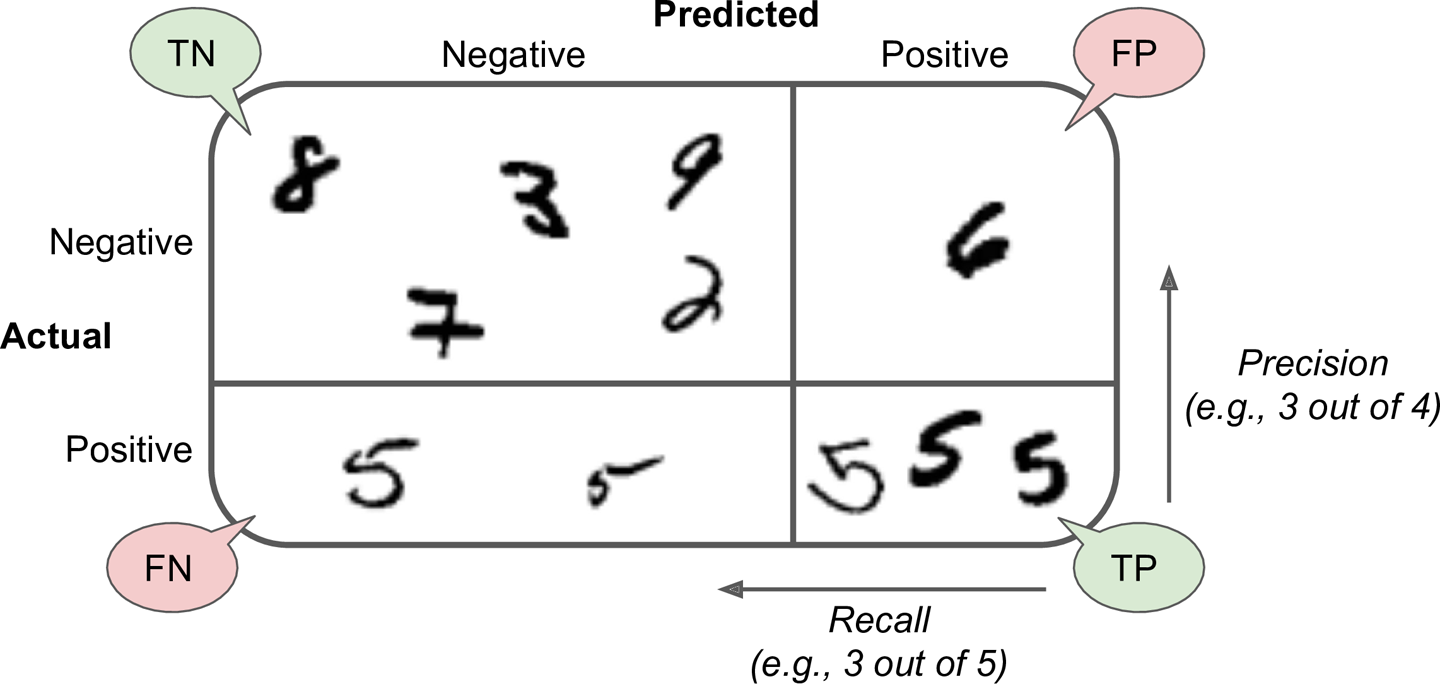

### Precision and Recall
The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called the ***precision*** of the classifier.
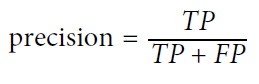

TP is the number of true positives, and FP is the number of false positives.

The ratio of positive instances that are correctly detected by the classifier; ***named recall, also called sensitivity or true positive rate*** 
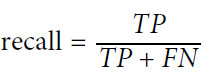
FN is of course the number of false negatives.

In [34]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.754513244474439

In [35]:
recall_score(y_train_5, y_train_pred)

0.8249400479616307

When it claims an image represents a 5, it is correct only 75% of the time. Moreover, it only detects 82% of the 5s.

## Precision/Recall Tradeoff

#### How the SGDClassifier makes its classification decisions. 
For each instance, it computes a score based on a ***decision function***, and if that score is greater than a threshold, it assigns the instance to the positive class, or else it assigns it to the negative class.
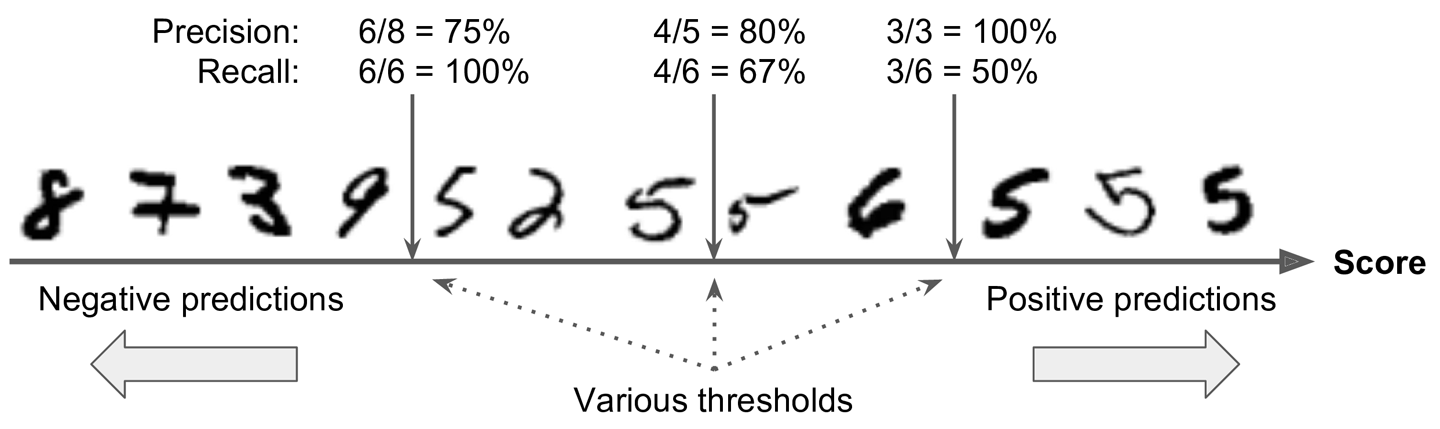
It shows a few digits positioned from the lowest score on the left to the highest score on the right.
Suppose the decision threshold is positioned at the central arrow (between the two 5s): you will find 4 true positives (actual 5s) on the right of that threshold, and one false positive (actually a 6). Therefore, with that threshold, the precision is 80% (4 out of 5). But out of 6
actual 5s, the classifier only detects 4, so the recall is 67% (4 out of 6). Now if you
raise the threshold (move it to the arrow on the right), the false positive (the 6)
becomes a true negative, thereby increasing precision (up to 100% in this case), but
one true positive becomes a false negative, decreasing recall down to 50%. Conversely,
lowering the threshold increases recall and reduces precision.

<br> Scikit-Learn give you access to the decision scores that it uses to make predictions. you can call its decision_function() method, which returns a score for each instance, and then make predictions based on those scores using any threshold you want.


In [37]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([3251.81547403])

In [39]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

The SGDClassifier uses a threshold equal to 0, so the previous code returns the same
result as the predict() method (i.e., True). Let’s raise the threshold:

In [44]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents
a 5, and the classifier detects it when the threshold is 0, but it misses it when the
threshold is increased to 8,000. <br> 
#### So how can you decide which threshold to use?
You first need to get the scores of all instances in the training set using the cross_val_predict() function again, but this time specifying that you want it to return decision scores instead of predictions:

In [45]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Now with these scores you can compute precision and recall for all possible thresholds using the precision_recall_curve() function

In [46]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finally, you can plot precision and recall as functions of the threshold value using Matplotlib

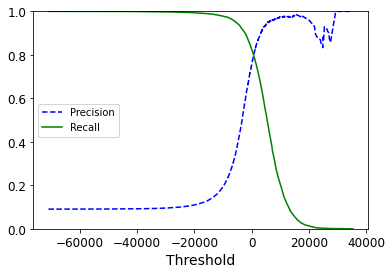

In [47]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

You may wonder why the precision curve is bumpier than the recall
curve in Figure 3-4. The reason is that precision may sometimes go
down when you raise the threshold (although in general it will go
up). To understand why, look back at Figure 3-3 and notice what
happens when you start from the central threshold and move it just
one digit to the right: precision goes from 4/5 (80%) down to 3/4
(75%). On the other hand, recall can only go down when the threshold
is increased, which explains why its curve looks smooth.

Now you can simply select the threshold value that gives you the best precision/recall
tradeoff for your task. Another way to select a good precision/recall tradeoff is to plot
precision directly against recall,

So let’s suppose you decide to aim for 90% precision. You look up the first plot and find that you need to use a threshold of about 70,000. To make predictions , instead of calling the classifier’s predict() method, you can just run this code:

In [50]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3214.5843500411293

In [52]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)


0.9

In [53]:
recall_score(y_train_5, y_train_pred_90)

0.6640841173215274

## The ROC Curve
The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers.<br>
the ROC curve plots the true positive rate (TPR) (another name for recall) against the false positive rate (FPR).<br>
To plot the ROC curve, you first need to compute the TPR and FPR for various threshold values, using the roc_curve() function:

In [54]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

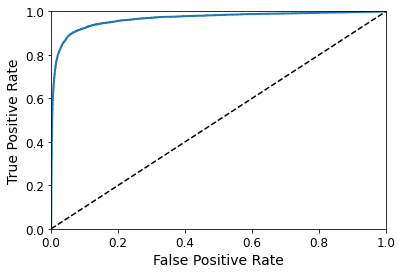

In [55]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

Once again there is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

<br> One way to compare classifiers is to measure the area under the curve (AUC). A perfect
classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5.

In [56]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9660259463088996

**NOTE:** Since the ROC curve is so similar to the precision/recall (or PR)
curve, you may wonder how to decide which one to use. As a rule
of thumb, you should prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives, and the ROC curve otherwise. For example,
looking at the previous ROC curve (and the ROC AUC score), you
may think that the classifier is really good. But this is mostly
because there are few positives (5s) compared to the negatives
(non-5s). In contrast, the PR curve makes it clear that the classifier
has room for improvement (the curve could be closer to the topright
corner).

### RandomForestClassifier
First, you need to get scores for each instance in the
training set. But due to the way it works , the RandomForestClassifier class does not have a decision_function() method. Instead it has a predict_proba() method. <br>
The predict_proba() method returns an array containing a row per instance and a column per class, each containing **the probability** that the given instance belongs to the given class.(e.g., 70% chance that the image represents a 5):

In [57]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

But to plot a ROC curve, you need scores, not probabilities. A simple solution is to
use the positive class’s probability as the score

In [58]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Now you are ready to plot the ROC curve. It is useful to plot the first ROC curve as
well to see how they compare

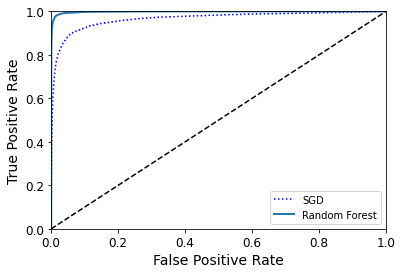

In [59]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [60]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983631764491033

## Your Turn! 
Try measuring the precision and recall scores:

In [ ]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

In [ ]:
recall_score(y_train_5, y_train_pred_forest)

# Multiclass Classification

Some algorithms (such as **Random Forest classifiers or naive Bayes classifiers**) are capable of handling multiple classes directly. <br>
Others (such as **Support Vector Machine classifiers or Linear classifiers**) are strictly binary classifiers.
<br> However, there are various strategies that you can use to perform multiclass classification using multiple binary classifiers.

1. one way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on).- This is called the ***one-versus-all (OvA)*** strategy
2. Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. -- This is called the ***one-versus-one (OvO)*** strategy. (For N classes, need N × (N – 1) / 2 classifiers)

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO).

In [62]:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

## Multilabel Classification
In some cases you may want your classifier to output multiple classes for each instance.<BR>

E.g. a face-recognition classifier: it should attach one label per person it recognizes. Say the classifier has been trained to recognize three faces, Alice, Bob, and Charlie; then when it is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning “Alice yes, Bob no, Charlie yes”). Such a classification system that outputs multiple binary labels is called ***a multilabel classification system.***